#2.155/6 Challenge Problem 2
<font size="1">
  Created by L. Regenwetter in Oct. 2023;   Artwork by Jessica Shung. </font>

In [1]:
%cd CP2_2023_public/

/home/turbo/nicksung/cp2/CP2_2023_public


In [2]:
from utils_public import *
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, concatenate

2023-10-25 21:57:03.360426: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-25 21:57:03.361494: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-25 21:57:03.381647: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-25 21:57:03.381943: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 21:57:03.729349: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

## Understanding City Zoning:
Cities are often comprised of districts. Typically, the city government zones areas allowing them some amount of control over what goes on in each distict. To simplify, we will be represing city districts as discrete spaces in a 7x7 grid. Each grid space will be filled with exactly one of five types of zones. We will discuss the districts below:

**Residential Zones [0]:** Residential zones are comprised primarily of housing and are where the workforce lives

**Industrial Zones [1]:** Industrial zones are the manufacturing centers of the city, packed with factories producing food and goods.

**Commercial Zones [2]:** Commercial zones are the retail hubs of the city, consisting of markets, stores, and restaurants.

**Park Zones [3]:** City parks are the green spaces of the city -- small tastes of nature within an urban environment.

**Office Zones [4]:** Office zones are the enterprise centers of global corporations and local businesses alike.

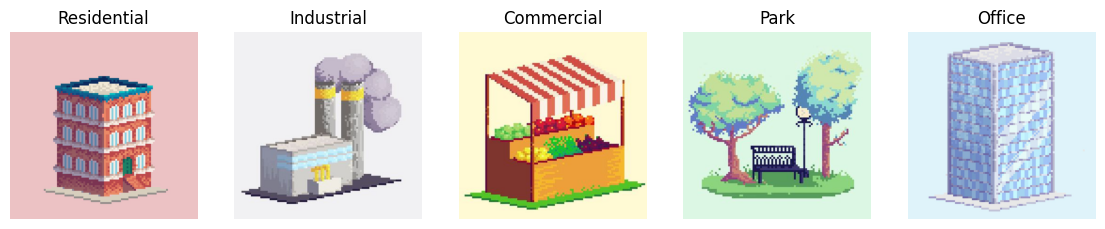

In [4]:
plot_districts()

## The Data
The mayor has provided you access to a large dataset of 500,000 possible zoning configurations. Additionally, the mayor asked the advisors to score some of these zoning configurations according to their subjective opinions of efficacy. Since the advisors are "only human" they have only been able to label ~5,000 configurations each. Some of their assessments may seem questionable to you, but they mayor insists that the advisors are "experts" and their ratings should not be questioned.

Let's take a look at the data. First, lets have a look at the zoning layouts you are given.

In [5]:
grids = load_grids() #Helper function we have provided to load the grids from the dataset
grids.shape #Check shape

(500000, 7, 7)

Let's examine the first grid in the dataset. It consists of 7x7 entries, each ranging from 0 to 4. The entries denote the district occupying the grid space (labeled above).

In [6]:
grids[0]

array([[4., 3., 0., 2., 3., 4., 4.],
       [0., 2., 0., 4., 3., 0., 3.],
       [4., 1., 0., 0., 1., 0., 3.],
       [2., 1., 2., 1., 3., 1., 1.],
       [2., 2., 2., 2., 4., 2., 3.],
       [2., 0., 0., 2., 0., 1., 0.],
       [4., 2., 4., 1., 3., 2., 4.]])

Let's visualize some of these grids. We have provided some utilities, mainly fucused on visualization, which we imported at the top of the notebook.

<Figure size 640x480 with 0 Axes>

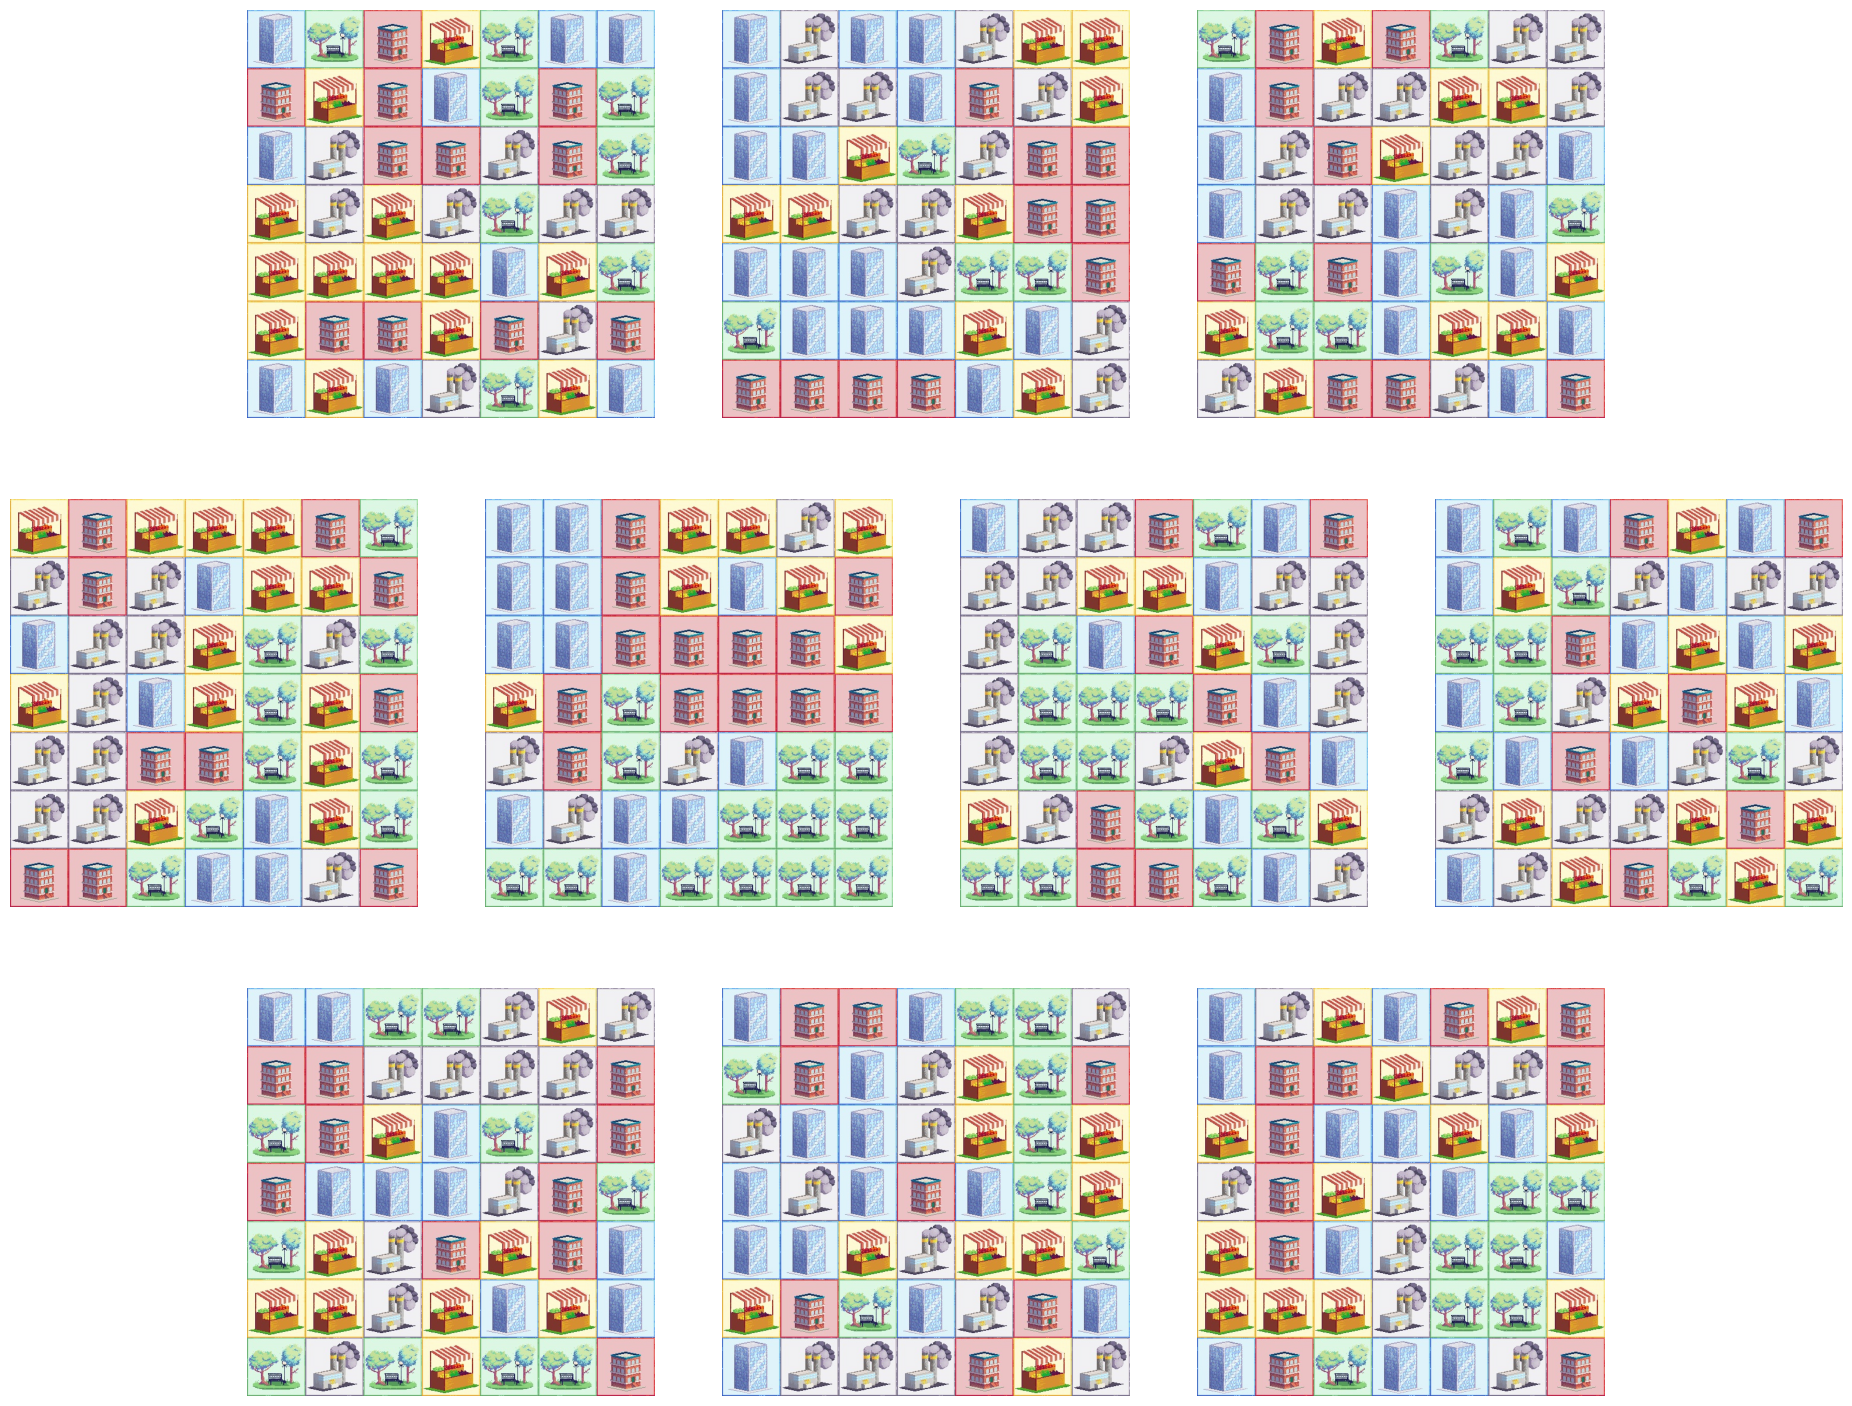

In [7]:
plot_n_grids(grids[:10]) #Plotting function that plots some number of grids in a clean layout

Now lets have a look at the advisor scores:

In [8]:
ratings = np.load("datasets/scores.npy") #Load advisor scores
score_order = ["Wellness", "Tax", "Transportation", "Business"] #This is the order of the scores in the dataset
ratings_df = pd.DataFrame(ratings, columns = score_order) #Create a dataframe
display(ratings_df) #Print dataframe

,Wellness,Tax,Transportation,Business
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
499995,NaN,NaN,NaN,NaN
499996,NaN,NaN,NaN,NaN
499997,NaN,NaN,NaN,NaN
499998,NaN,NaN,NaN,NaN


We can see that the vast majority of ratings are NaN. After all, only 1% of the data is labeled. Let's confirm that there are the right number of NaNs in each column:

In [9]:
ratings_df.isna().sum()

Wellness          495001
Tax               495002
Transportation    495001
Business          495000
dtype: int64

Let's plot the distribution over the scores that are rated. We see that each advisor's scores are fairly uniform from 0 to 1.

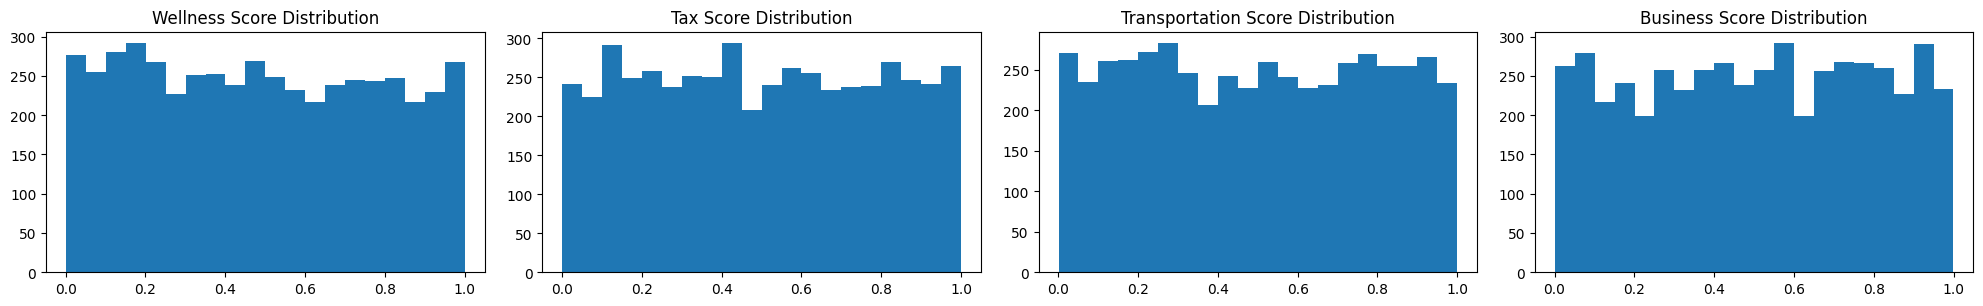

In [10]:
plot_ratings_histogram(ratings)

## The Task:
**Satisfying the Advisors:**
You are tasked with finding zoning layouts that "satisfy" all four advisors, meaning that they each assign a score of at least 0.85. If even one of the advisors rates a layout under a 0.85, it will be rejected as a candidate. You much identify designs from the dataset or generate new designs that *you believe* will be accepted by the advisors.

**Identifying a diverse set:** The mayor has asked for a variety of "diverse" design candidates -- 100 city layouts to be exact -- which they will show to the advisors. The overall diversity of all valid (non-rejected) designs will be calculated. With this diversity metric, more designs is always better, so it is in your best interest to ensure that as few of your submitted designs are rejected as possible.

We have provided the function we will use to evaluate diversity. Here are a few tests to build some intuition with the diversity score.

### Building Intuition for Diversity

In [11]:
grids = load_grids() #Helper function we have provided to load the grids from the dataset
grids.shape #Check shape

(500000, 7, 7)

In [12]:
ratings = np.load("datasets/scores.npy") #Load advisor scores
score_order = ["Wellness", "Tax", "Transportation", "Business"] #This is the order of the scores in the dataset
ratings_df = pd.DataFrame(ratings, columns = score_order) #Create a dataframe
display(ratings_df) #Print dataframe

,Wellness,Tax,Transportation,Business
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
499995,NaN,NaN,NaN,NaN
499996,NaN,NaN,NaN,NaN
499997,NaN,NaN,NaN,NaN
499998,NaN,NaN,NaN,NaN


In [13]:
def compute_distance_to_class(grid, target_class):
    # Find the positions of the target class
    positions_target_class = np.argwhere(grid == target_class)
    
    # Initialize a distance matrix with large values
    distance_matrix = np.full(grid.shape, np.inf)
    
    for i in range(7):
        for j in range(7):
            for pos in positions_target_class:
                distance = np.linalg.norm(np.array([i, j]) - pos)
                distance_matrix[i, j] = min(distance_matrix[i, j], distance)
    
    return distance_matrix.flatten()

In [14]:
def compute_max_min_distance(grid, class_type_1, class_type_2):
    # Find the positions of the two class types
    positions_type_1 = np.argwhere(grid == class_type_1)
    positions_type_2 = np.argwhere(grid == class_type_2)

    # If either class type is not found in the grid, return None for min and max distances
    if len(positions_type_1) == 0 or len(positions_type_2) == 0:
        return None, None

    # Calculate all pairwise distances between the two sets of positions
    distances = []
    for pos1 in positions_type_1:
        for pos2 in positions_type_2:
            distance = np.linalg.norm(pos1 - pos2)
            distances.append(distance)

    # Return the minimum and maximum of the calculated distances
    return [float(min(distances)), float(max(distances))]

In [15]:
def count_connected_for_class(grid, target_class):
    height, width = grid.shape
    count = 0

    for i in range(height):
        for j in range(width):
            if grid[i][j] == target_class:
                # Check bottom neighbor
                if i + 1 < height and grid[i+1][j] == target_class:
                    count += 1

                # Check right neighbor
                if j + 1 < width and grid[i][j+1] == target_class:
                    count += 1

    return count

In [16]:
def compute_features(grid, advisor):

    features = []
    grid = grid.astype(int)
    # Number of each type
    counts = np.bincount(grid.flatten(), minlength=5)
    features.extend(counts)
    # number of times a cell of class i is adjacent to a cell of class j.
    inter_adjacency = np.zeros((5, 5), dtype=int)
    
    for i in range(7):
        for j in range(7):
            current_val = grid[i, j]
            for dx, dy in [(1, 0), (0, 1), (-1, 0), (0, -1)]:
                if 0 <= i+dx < 7 and 0 <= j+dy < 7:
                    neighbor_val = grid[i+dx, j+dy]
                    # Only update the upper diagonal (including main diagonal)
                    if current_val <= neighbor_val:
                        inter_adjacency[current_val, neighbor_val] += 1
                    
    features.extend(inter_adjacency[np.triu_indices(5, k=0)])

    # Create a dictionary to store distances for each unique class pair
    distances = {(i, j): [] for i in range(5) for j in range(i, 5)}

    # Compute distances for each pair of cells
    for i in range(7):
        for j in range(7):
            for m in range(7):
                for n in range(7):
                    d = np.sqrt((i - m) ** 2 + (j - n) ** 2)
                    class_pair = tuple(sorted([grid[i, j], grid[m, n]]))
                    distances[class_pair].append(d)

    # Compute statistics for each class pair and store in a flattened list
    flattened_stats = []

    for key, values in distances.items():
        if values:  # Check if the list is not empty
            try:
                mean_val = np.mean(values)
                var_val = np.var(values)
            except:
                mean_val = 0  
                var_val = 0 
            flattened_stats.extend([mean_val, var_val])
        else:  # Handle the case where the list is empty
            flattened_stats.extend([0, 0])  # or any default value
    
    if advisor == 0:
        " Wellness advisor is focused on the health and wellbeing (both physical and mental) of citizens"
        " They are very invested in the quality and accessibility of city's green spaces."
        # Distance of park zones from each grid element
        distance_matrix = compute_distance_to_class(grid, target_class = 3)
        features.extend(distance_matrix)
        # Number of connected parks
        connections = count_connected_for_class(grid, target_class= 3)
        features.extend([connections])
        
    if advisor == 2:
        " Transportation advisor places an emphasis on accessibility and emissions. "
        " They are focused on mimizing the distance over which the workforce needs to commute."
        for cls in [0, 1, 2, 4]:
                   
            # obtains the minimum and max distance between residential areas and three others
            # max_min = compute_max_min_distance(grid, class_type_1 = 0, class_type_2 = cls)
            # features.extend(max_min)
            # obtains distance to nearest residential
            distance_matrix = compute_distance_to_class(grid, target_class = cls)
            features.extend(distance_matrix)

            # could possibly add proximity of houses at the centre

    
    return features

In [17]:
from multiprocessing import Pool, cpu_count
from functools import partial

def parallel_compute(grids, advisor):
    with Pool(cpu_count()) as p:
        # Partially apply the advisor to the compute_features function
        func = partial(compute_features, advisor=advisor)
        # Map the function over grids
        return np.array(p.starmap(func, [(grid,) for grid in grids]))



In [18]:
def one_hot_encode(grid):
    # The shape of grids_oh will be (7, 7, 5) after one-hot encoding
    grids_oh = (np.arange(5) == grid[..., None]).astype(int)
    return grids_oh

In [19]:
advisor_val = 2
grids_subset, ratings_subset = select_rated_subset(grids, ratings[:,advisor_val]) #gets subset of the dataset rated by advisor 2
grids_encoded = np.array([one_hot_encode(grid) for grid in grids_subset])

# First split: 80% for training, 20% for temp (to be divided into test and validation)
grids_train, grids_test, ratings_train, ratings_test = train_test_split(grids_encoded, ratings_subset, test_size=0.2, random_state=20)


In [20]:
features_subset = parallel_compute(grids_subset, advisor_val)
features_subset[np.isnan(features_subset)] = 0
features_train, features_test, ratings_train, ratings_test = train_test_split(features_subset, ratings_subset, test_size=0.2, random_state=20)

In [21]:
grids_train = grids_train.astype(np.float32)
features_train = features_train.astype(np.float32)
grids_test = grids_test.astype(np.float32)
features_test = features_test.astype(np.float32)

In [22]:
# #Convert to dataframe and specify dtype of object to ensure categorical handling of data
# features_train = pd.DataFrame(features_train, columns = range(features_subset.shape[1]), dtype = "object")
# features_test = pd.DataFrame(features_test, columns = range(features_subset.shape[1]), dtype = "object")

# #Convert ratings to dataframe and label the column so we can tell Autogluon what to predict
# preds_train = pd.DataFrame(ratings_train, columns = ["ratings"])

# #Concatenate train grids and ratings together
# all_train = pd.concat([features_train, preds_train], axis=1)
# display(all_train) #Have a look to check things over

In [23]:
# Optimal hyperparameters: {'batch_size': 64, 'conv_layer_size': 92, 'dense_layer_size': 84, 'epochs': 29, 'learning_rate': 0.003837244776335524, 'num_conv_layers': 2, 'num_dense_layers': 4}
# Optimal hyperparameters: {'batch_size': 64, 'conv_layer_size': 171, 'dense_layer_size': 84, 'epochs': 29, 'learning_rate': 0.003837244776335524, 'num_conv_layers': 2, 'num_dense_layers': 4}


def create_combined_model(num_conv_layers=2, conv_layer_size=171, num_dense_layers=4, dense_layer_size=84, learning_rate=0.003837244776335524):
    
    # Convolutional Branch
    input_grid = Input(shape=(7, 7, 5))
    x = input_grid
    
    # Add convolutional layers dynamically
    for _ in range(num_conv_layers):
        x = Conv2D(conv_layer_size, (3, 3), activation='relu', padding='same')(x)
        
    x = Flatten()(x)
    x = Dense(dense_layer_size, activation='relu')(x)
    conv_branch = Dense(dense_layer_size, activation='relu')(x)
    
    # Dense Branch
    input_features = Input(shape=(216,))
    y = input_features
    
    # Add dense layers dynamically
    for _ in range(num_dense_layers):
        y = Dense(dense_layer_size, activation='relu')(y)
        
    dense_branch = Dense(dense_layer_size, activation='relu')(y)
    
    # Combining the two branches
    combined = concatenate([conv_branch, dense_branch])
    combined = Dense(dense_layer_size, activation='relu')(combined)
    combined = Dense(int(dense_layer_size/2), activation='relu')(combined)
    output = Dense(1)(combined)

    # Use the learning rate in the optimizer
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    # Create the model
    model = Model(inputs=[input_grid, input_features], outputs=output)
    
    # Compile the model with the custom optimizer
    model.compile(optimizer=optimizer, loss='mse')
   
    
    return model

In [24]:
model = create_combined_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 7, 7, 5)]            0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 216)]                0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 7, 7, 171)            7866      ['input_1[0][0]']             
                                                                                                  
 dense_2 (Dense)             (None, 84)                   18228     ['input_2[0][0]']             
                                                                                              

2023-10-25 21:57:08.793453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-25 21:57:08.793542: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-25 21:57:08.811024: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the 

In [25]:
# Train the model
# Define training parameters
batch_size = 64
epochs = 29

model.fit([grids_train, features_train], ratings_train, epochs=epochs, batch_size=batch_size)

Epoch 1/29
63/63 [==============================] - 1s 6ms/step - loss: 0.1217
Epoch 2/29
63/63 [==============================] - 0s 6ms/step - loss: 0.0789
Epoch 3/29
63/63 [==============================] - 0s 6ms/step - loss: 0.0509
Epoch 4/29
63/63 [==============================] - 0s 6ms/step - loss: 0.0291
Epoch 5/29
63/63 [==============================] - 0s 6ms/step - loss: 0.0202
Epoch 6/29
63/63 [==============================] - 0s 6ms/step - loss: 0.0139
Epoch 7/29
63/63 [==============================] - 0s 6ms/step - loss: 0.0105
Epoch 8/29
63/63 [==============================] - 0s 6ms/step - loss: 0.0085
Epoch 9/29
63/63 [==============================] - 0s 6ms/step - loss: 0.0072
Epoch 10/29
63/63 [==============================] - 0s 5ms/step - loss: 0.0063
Epoch 11/29
63/63 [==============================] - 0s 6ms/step - loss: 0.0048
Epoch 12/29
63/63 [==============================] - 0s 6ms/step - loss: 0.0037
Epoch 13/29
63/63 [==============================

In [26]:
preds_train = model.predict([grids_train, features_train])
preds_test = model.predict([grids_test, features_test])

32/32 [==============================] - 0s 1ms/step


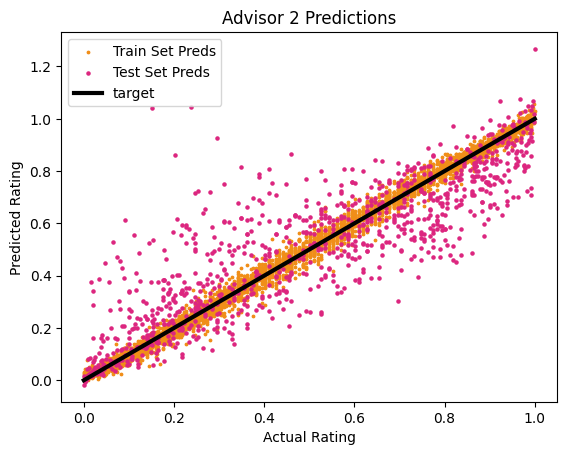

Train Set R2 score: 0.992321017866887
Test Set R2 score: 0.7339385177230748


In [27]:
from sklearn.metrics import r2_score
def plot_and_r2(preds_train, preds_test, ratings_train, ratings_test, i):
    plt.scatter(ratings_train, preds_train, label='Train Set Preds', s=3, c = "#F08E18") #Train set in orange
    plt.scatter(ratings_test, preds_test, label='Test Set Preds', s=5, c = "#DC267F") #Test set in magenta
    plt.plot([0,1], [0,1], label="target", linewidth=3, c="k") # Target line in Black
    plt.xlabel("Actual Rating")
    plt.ylabel("Predicted Rating")
    plt.title(f"Advisor {i} Predictions")
    plt.legend()
    plt.show()
    print(f"Train Set R2 score: {r2_score(ratings_train, preds_train)}") #Calculate R2 score
    print(f"Test Set R2 score: {r2_score(ratings_test, preds_test)}")
plot_and_r2(preds_train, preds_test, ratings_train, ratings_test, advisor_val)